## Train ViT-B-16 on CIFAR-10

In [1]:
import os
import torch
import yaml
import utils
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
MODEL_NAME = 'ViT-B-16'
DATASET_NAME = 'CIFAR-10'
BATCH_SIZE = 32
EPOCHS = 200
IMG_SIZE = 224
NUM_CLASSES = 10

In [5]:
model = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')
model.heads.head.out_features = NUM_CLASSES
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Files already downloaded and verified
Files already downloaded and verified


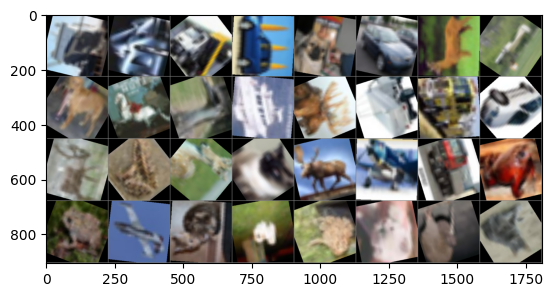

ship  car   truck car   dog   car   deer  plane dog   horse bird  ship  deer  truck truck car   deer  frog  deer  cat   deer  plane truck frog  frog  plane cat   dog   frog  cat   bird  cat  


In [6]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE,IMG_SIZE)),
     torchvision.transforms.RandomRotation(degrees=90.0),
     torchvision.transforms.RandomVerticalFlip(p=0.5),
     torchvision.transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

data_iter = iter(train_loader)
images, labels = next(data_iter)

utils.imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [ ]:
save_path = f'./checkpoints/{MODEL_NAME}_{DATASET_NAME}'.lower()

config = {
    'model_name': MODEL_NAME,
    'dataset': DATASET_NAME,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'img_size': IMG_SIZE,
    'num_classes': NUM_CLASSES
}

results_data = {
    'epoch': [], 
    'train_loss': [], 
    'test_loss': [], 
    'train_acc': [], 
    'test_acc': []
}

res_df = pd.DataFrame(results_data)

if(not os.path.exists(f'{save_path}/')):
    os.makedirs(f'{save_path}')

with open(f'{save_path}/config.yaml', 'w') as yaml_file:
    yaml.dump(config, yaml_file, default_flow_style=False)

best_test_acc = 0.0
    
for epoch in range(EPOCHS):

    train_loaders = [train_loader]

    for train_loader in train_loaders:

        train_loss_batches = []
        train_correct_preds_batches = []
        train_count = 0
        
        for i, (images, labels) in enumerate(train_loader):

            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            optimizer.zero_grad()

            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            
            train_loss_curr = criterion(outputs, labels)
            train_loss_curr.backward()
            optimizer.step()
            
            train_count = train_count+len(images)

            train_loss_batch = train_loss_curr.item()
            train_loss_batches.append(train_loss_batch)
            train_loss = round(np.sum(np.array(train_loss_batches))/train_count, 4)

            train_correct_preds_batch = (preds == labels).sum().item()
            train_correct_preds_batches.append(train_correct_preds_batch)
            train_acc = round(np.sum(train_correct_preds_batches)/train_count, 4)

            print(f'Train --> {train_acc}')
            
    test_loaders = [test_loader]

    with torch.no_grad():
        
        for test_loader in test_loaders:

            test_loss_batches = []
            test_correct_preds_batches = []
            test_count = 0
            
            for i, (images, labels) in enumerate(test_loader):
    
                if torch.cuda.is_available():
                    images = Variable(images.cuda())
                    labels = Variable(labels.cuda())
    
                outputs = model(images)
                preds = torch.argmax(outputs, 1)
                
                test_loss_curr = criterion(outputs, labels)

                test_count = test_count+len(images)
    
                test_loss_batch = test_loss_curr.item()
                test_loss_batches.append(test_loss_batch)
                test_loss = round(np.sum(np.array(test_loss_batches))/test_count, 4)
    
                test_correct_preds_batch = (preds == labels).sum().item()
                test_correct_preds_batches.append(test_correct_preds_batch)
                test_acc = round(np.sum(test_correct_preds_batches)/test_count, 4)

                rint(f'Test --> {test_acc}')
    
    print(f'Epoch {epoch+1} - Train loss: {train_loss}, Test loss: {test_loss}, Train accuracy: {train_acc}, Test accuracy: {test_acc}')

    results_data = {
        'epoch': epoch+1, 
        'train_loss': train_loss, 
        'test_loss': test_loss, 
        'train_acc': train_acc, 
        'test_acc': test_acc
    }
    
    if(not os.path.exists(f'{save_path}/weights')):
        os.makedirs(f'{save_path}/weights')

    res_df.loc[len(res_df)] = results_data
    res_df.to_csv(f'{save_path}/results.csv', index=False)

    torch.save(model, f'{save_path}/weights/last.pt')

    if(test_acc > best_test_acc):
        torch.save(model, f'{save_path}/weights/best.pt')
        best_test_acc = test_acc

        print(f'Saved checkpoint related to better accuracy score: {best_test_acc}')

Train --> 0.0
Train --> 0.0
Train --> 0.0
Train --> 0.0
Train --> 0.0
Train --> 0.0052
Train --> 0.0089
Train --> 0.0195
Train --> 0.0243
Train --> 0.0375
Train --> 0.0455
Train --> 0.0599
Train --> 0.0625
Train --> 0.0692
Train --> 0.0792
Train --> 0.082
Train --> 0.0882
Train --> 0.0903
Train --> 0.0921
Train --> 0.0938
Train --> 0.0982
Train --> 0.1037
Train --> 0.106
Train --> 0.1107
Train --> 0.115
Train --> 0.1178
Train --> 0.1204
Train --> 0.1217
Train --> 0.1239
Train --> 0.124
Train --> 0.122
Train --> 0.124
Train --> 0.1231
Train --> 0.1278
Train --> 0.1286
Train --> 0.1345
Train --> 0.1377
Train --> 0.1447
Train --> 0.1514
Train --> 0.1539
Train --> 0.1616
Train --> 0.1652
Train --> 0.1664
Train --> 0.1669
Train --> 0.1681
Train --> 0.1739
Train --> 0.1762
Train --> 0.1784
Train --> 0.183
Train --> 0.1875
Train --> 0.193
Train --> 0.1953
Train --> 0.1969
Train --> 0.2008
Train --> 0.2006
Train --> 0.2026
Train --> 0.205
Train --> 0.208
Train --> 0.2097
Train --> 0.212
Train 